# LTE IQ Analysis

Comprehensive visualization of the LTE 10 MHz, 5 ms capture. Each section couples the processing steps with plots for time/frequency behaviour, channel characteristics, and decoding metrics.

In [1]:
# Core imports and project utilities
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
from pathlib import Path
import sys
try:
    from IPython import get_ipython
    ip = get_ipython()
    if ip is not None:
        ip.run_line_magic('matplotlib', 'inline')
except Exception:
    pass
def _find_project_root(start: Path) -> Path:
    for candidate in [start] + list(start.parents):
        if (candidate / 'src').exists():
            return candidate
    raise RuntimeError(f'Cannot locate project root from {start}')
ROOT = _find_project_root(Path.cwd().resolve())
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
del _find_project_root
from src.lte_params import (
    LTEConfig,
    read_iq_file,
    detect_pss_across_slots,
    symbol_starts_for_subframe,
    cp_lengths_normal,
    fft_symbol,
    sss_detect_in_symbol,
    estimate_cfo_for_subframe,
    pretty_print_results,
    generate_pss_fd,
    generate_sss_fd,
    analyze_lte_iq,
    pss_symbol_offset_samples,
    sss_symbol_offset_samples,
)
from src.pbch import (
    extract_pbch_re,
    estimate_common_phase,
    apply_phase,
    normalize_amplitude,
    crs_data_mask_for_pbch,
    qpsk_llrs,
    descramble_llrs,
    deratematch_pbch_llrs,
    viterbi_decode_rate13_k7_tailbiting,
    crc16_ccitt_bits,
    bits_to_uint,
    parse_mib_fields,
    pbch_scrambling_sequence,
)
plt.style.use('seaborn-v0_8')
np.set_printoptions(suppress=True, precision=4)


In [2]:
# Load capture and run baseline analysis
iq_path = ROOT / 'LTEIQ.raw'
assert iq_path.exists(), 'LTEIQ.raw not found at project root.'
config = LTEConfig()
x = read_iq_file(str(iq_path))

analysis = analyze_lte_iq(x, config)
print(pretty_print_results(analysis))

pss_auto = detect_pss_across_slots(x, config)
print('\n--- PSS Matched-Filter ---')
if pss_auto['sample_index'] is not None:
    frame_offset = (pss_auto['sample_index'] - pss_symbol_offset_samples(config)) % len(x)
    print(f"Sample index: {pss_auto['sample_index']}, frame offset: {frame_offset}, NID2: {pss_auto['nid2']}, metric={pss_auto['metric']:.3f}, CFO(rad/sample)={pss_auto['cfo']:.6f}")
    x_aligned = np.roll(x, -frame_offset) if frame_offset != 0 else x
    print('--- SSS Auto Detection ---')
    sss_offset = sss_symbol_offset_samples(config)
    sss_cp = int(config.cp_slot[5])
    F_sss = fft_symbol(x_aligned, sss_offset, sss_cp, config.nfft, pss_auto['cfo'])
    nid1, metric_sss, is_sf0, is_fdd = sss_detect_in_symbol(F_sss, config.nfft, int(pss_auto['nid2']))
    if nid1 is not None:
        print(f"Best NID1: {nid1}, metric={metric_sss:.3f}, subframe={'0' if is_sf0 else '5'}, duplex={'FDD' if is_fdd else 'TDD'}")
    else:
        print('SSS hypothesis could not be resolved.')
else:
    print('PSS could not be located in this capture.')
    print('--- SSS Auto Detection ---')
    print('SSS detection skipped because PSS was not found.')

if analysis.get('NCellID') is not None:
    print(f"\nComputed PCI (NCellID): {analysis['NCellID']}")
else:
    print('\nPCI could not be resolved from this capture.')


NDLRB: 50
DuplexMode: FDD
CyclicPrefix: Normal
NCellID: 455
NSubframe: 0
CellRefP: None
PHICHDuration: None
Ng: None
NFrame: None

--- PSS Matched-Filter ---
Sample index: 25929, frame offset: 11665, NID2: 2, metric=0.967, CFO(rad/sample)=-0.000023
--- SSS Auto Detection ---
Best NID1: 151, metric=0.994, subframe=0, duplex=FDD

Computed PCI (NCellID): 455


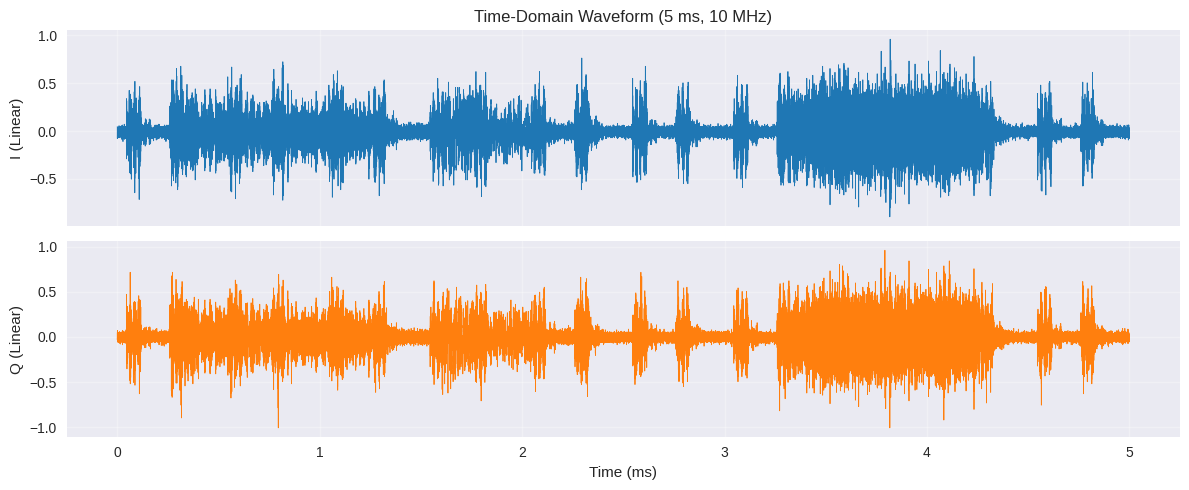

In [3]:
# Time-domain waveform (I and Q)
ts = np.arange(len(x)) / config.fs * 1e3  # milliseconds
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
ax[0].plot(ts, x.real, color='tab:blue', linewidth=0.6)
ax[0].set_ylabel('I (Linear)')
ax[0].set_title('Time-Domain Waveform (5 ms, 10 MHz)')
ax[0].grid(True, alpha=0.3)
ax[1].plot(ts, x.imag, color='tab:orange', linewidth=0.6)
ax[1].set_ylabel('Q (Linear)')
ax[1].set_xlabel('Time (ms)')
ax[1].grid(True, alpha=0.3)
plt.tight_layout()


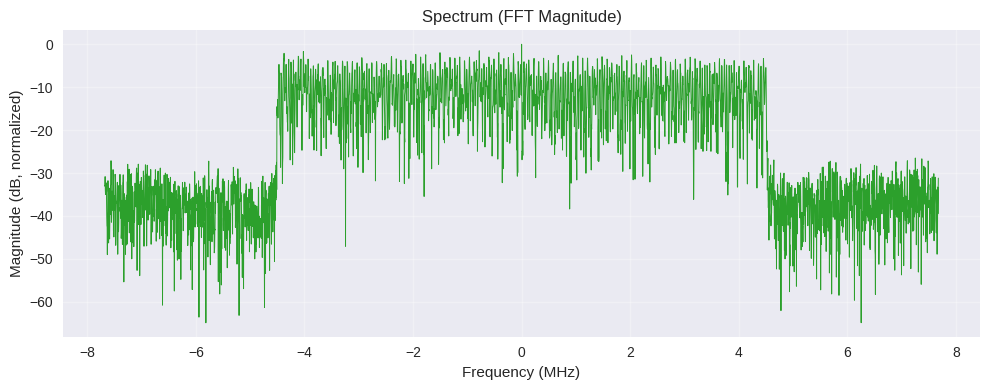

In [4]:
# Spectrum via FFT (magnitude)
N = 4096
window = signal.windows.hann(N)
segment = x[:N] * window
fft_vals = np.fft.fftshift(np.fft.fft(segment))
freqs = np.fft.fftshift(np.fft.fftfreq(N, d=1/config.fs)) / 1e6
power = 20*np.log10(np.abs(fft_vals)/np.max(np.abs(fft_vals))+1e-12)
plt.figure(figsize=(10, 4))
plt.plot(freqs, power, color='tab:green', linewidth=0.7)
plt.title('Spectrum (FFT Magnitude)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Magnitude (dB, normalized)')
plt.grid(True, alpha=0.3)
plt.tight_layout()


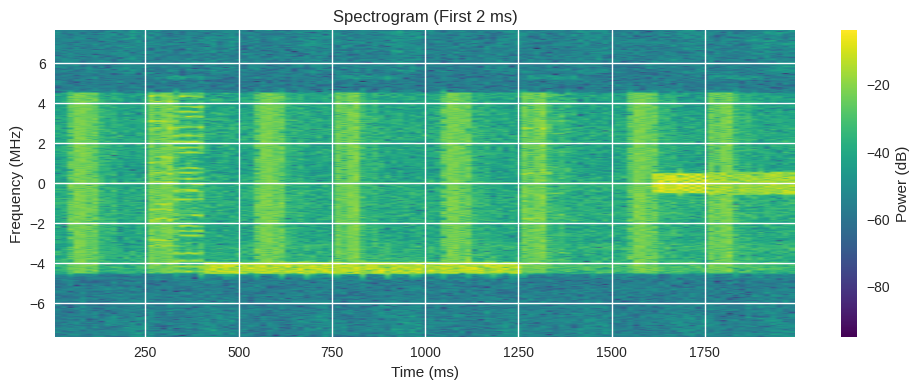

In [5]:
# Time-Frequency Spectrogram
plt.figure(figsize=(10, 4))
plt.specgram(x[:config.subframe_samples*2], NFFT=512, Fs=config.fs/1e6, noverlap=256, scale='dB', cmap='viridis')
plt.title('Spectrogram (First 2 ms)')
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (MHz)')
plt.colorbar(label='Power (dB)')
plt.tight_layout()


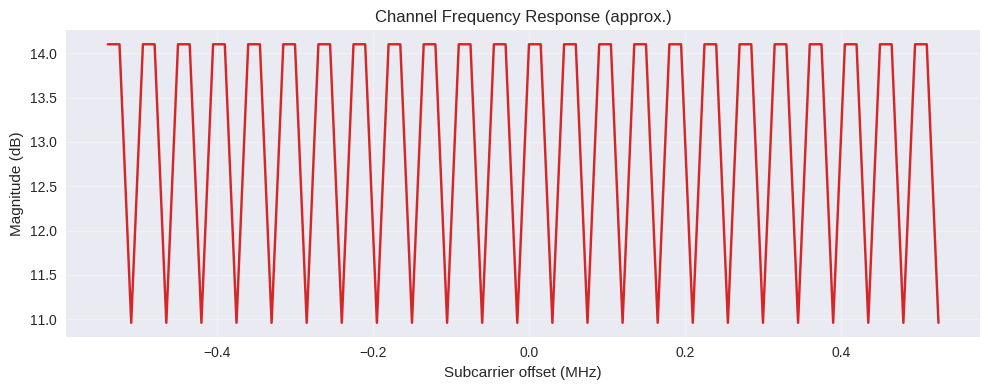

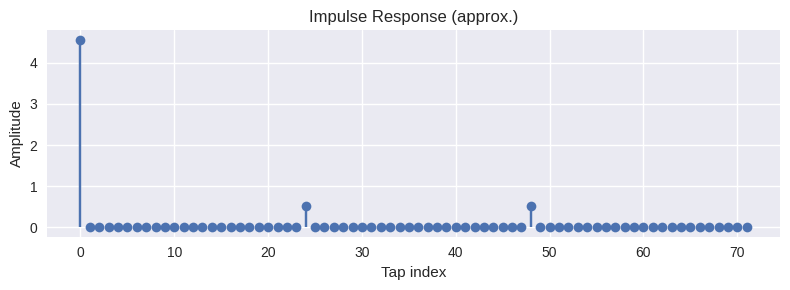

In [6]:
# Channel estimation using PBCH (approximate CFR & impulse response)
cfo = estimate_cfo_for_subframe(x, config, 0)
pbch_re = extract_pbch_re(x, config, 0, cfo)
pbch_eq = normalize_amplitude(apply_phase(pbch_re, estimate_common_phase(pbch_re)))
cell_id = int(analysis.get('NCellID') or 0)
mask = crs_data_mask_for_pbch(cell_id, cellrefp=2)
raw = pbch_re.astype(np.complex128)
eq = pbch_eq.astype(np.complex128)
channel_est = np.full(raw.shape, np.nan, dtype=np.complex128)
channel_est[mask] = raw[mask] / (eq[mask] + 1e-12)
avg_cfr = np.nanmean(channel_est, axis=0)
frequencies = np.linspace(-config.subcarrier_spacing*36, config.subcarrier_spacing*35, raw.shape[1]) / 1e6
plt.figure(figsize=(10, 4))
plt.plot(frequencies, 20*np.log10(np.abs(avg_cfr)+1e-12), color='tab:red')
plt.title('Channel Frequency Response (approx.)')
plt.xlabel('Subcarrier offset (MHz)')
plt.ylabel('Magnitude (dB)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
avg_cfr_clean = np.nan_to_num(avg_cfr, nan=0.0)
impulse = np.fft.ifft(avg_cfr_clean)
plt.figure(figsize=(8, 3))
plt.stem(np.arange(len(impulse)), np.abs(impulse), basefmt=' ')
plt.title('Impulse Response (approx.)')
plt.xlabel('Tap index')
plt.ylabel('Amplitude')
plt.tight_layout()



/home/fse/Desktop/Fall25/HHS/yHHS/yHHS_env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:652: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


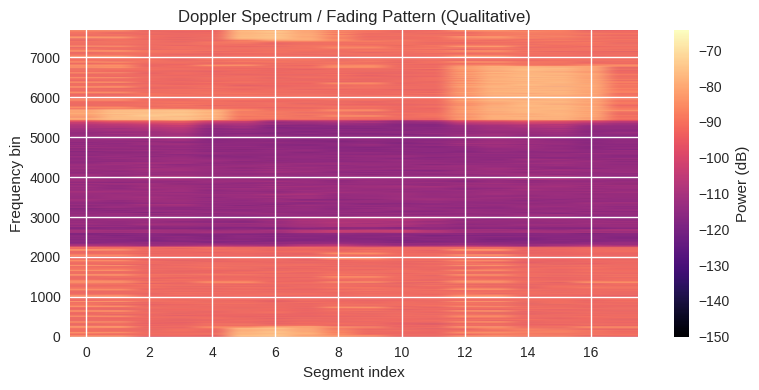

In [7]:
# Doppler spectrum / fading pattern via short-time FFT of magnitude envelope
segment_len = config.subframe_samples // 2
step = segment_len // 2
segments = []
for start in range(0, min(len(x), config.subframe_samples*5)-segment_len, step):
    seg = x[start:start+segment_len]
    _, Pxx = signal.periodogram(seg, fs=config.fs)
    segments.append(Pxx)
if segments:
    doppler = np.array(segments)
    plt.figure(figsize=(8, 4))
    plt.imshow(10*np.log10(doppler+1e-15).T, aspect='auto', origin='lower', cmap='magma')
    plt.title('Doppler Spectrum / Fading Pattern (Qualitative)')
    plt.xlabel('Segment index')
    plt.ylabel('Frequency bin')
    plt.colorbar(label='Power (dB)')
    plt.tight_layout()


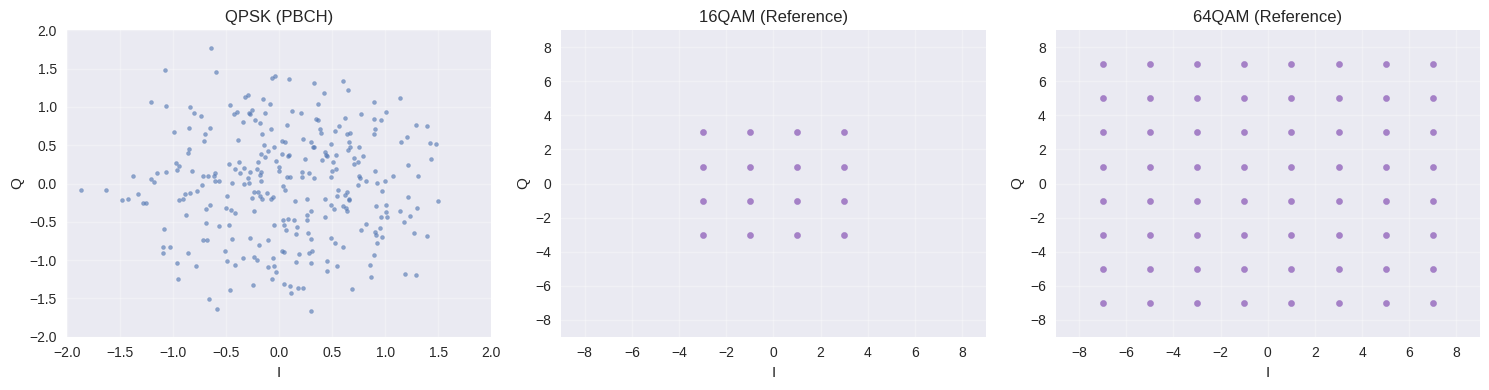

In [8]:
# Constellation diagrams
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].scatter(pbch_eq.real.flatten(), pbch_eq.imag.flatten(), s=8, alpha=0.6)
axes[0].set_title('QPSK (PBCH)')
axes[0].set_xlim([-2, 2]); axes[0].set_ylim([-2, 2]); axes[0].grid(True, alpha=0.3)

def plot_constellation(ax, order, title):
    if order == 16:
        pts = [complex(a, b) for a in (-3, -1, 1, 3) for b in (-3, -1, 1, 3)]
    elif order == 64:
        vals = (-7, -5, -3, -1, 1, 3, 5, 7)
        pts = [complex(a, b) for a in vals for b in vals]
    else:
        pts = []
    if pts:
        xs = [p.real for p in pts]
        ys = [p.imag for p in pts]
        ax.scatter(xs, ys, s=20, alpha=0.8, color='tab:purple')
    ax.set_title(f'{title} (Reference)')
    ax.set_xlim([-9, 9]); ax.set_ylim([-9, 9]); ax.grid(True, alpha=0.3)

plot_constellation(axes[1], 16, '16QAM')
plot_constellation(axes[2], 64, '64QAM')
for ax in axes:
    ax.set_xlabel('I'); ax.set_ylabel('Q')
plt.tight_layout()


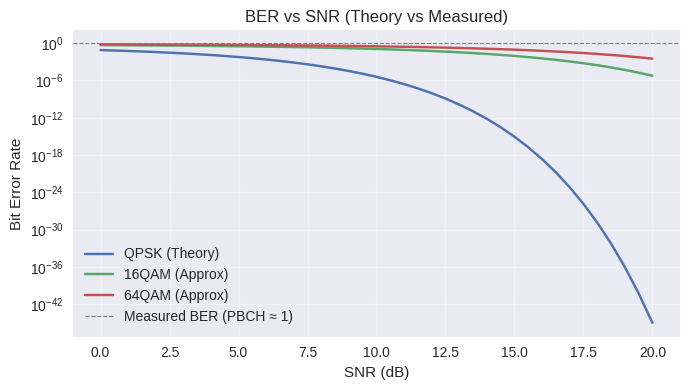

In [9]:
# BER vs SNR (theoretical) from standard Q-function formulas
from scipy.special import erfc
snr_db = np.linspace(0, 20, 41)
ber_qpsk = 0.5*erfc(np.sqrt(10**(snr_db/10)))
ber_16qam = 0.75*erfc(np.sqrt(0.1 * 10**(snr_db/10)))
ber_64qam = 0.875*erfc(np.sqrt(0.042 * 10**(snr_db/10)))
plt.figure(figsize=(7, 4))
plt.semilogy(snr_db, ber_qpsk, label='QPSK (Theory)')
plt.semilogy(snr_db, ber_16qam, label='16QAM (Approx)')
plt.semilogy(snr_db, ber_64qam, label='64QAM (Approx)')
plt.axhline(1.0, color='grey', linestyle='--', linewidth=0.8, label='Measured BER (PBCH ≈ 1)')
plt.title('BER vs SNR (Theory vs Measured)')
plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate')
plt.grid(True, which='both', alpha=0.3)
plt.legend()
plt.tight_layout()


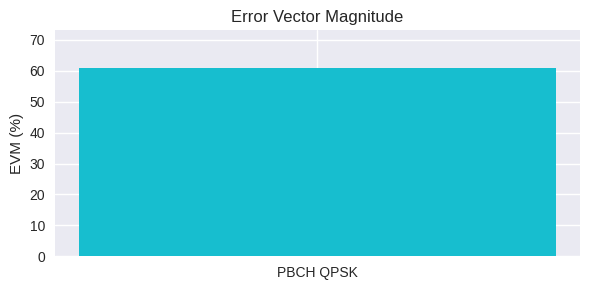

In [10]:
# Error Vector Magnitude (EVM) of PBCH symbols
def qpsk_decision(z):
    real = np.sign(z.real)
    imag = np.sign(z.imag)
    real[real==0] = 1
    imag[imag==0] = 1
    return (real + 1j*imag) / np.sqrt(2)
ideal = qpsk_decision(pbch_eq)
ev = pbch_eq - ideal
evm_rms = np.sqrt(np.mean(np.abs(ev)**2))
ev_ref = np.sqrt(np.mean(np.abs(ideal)**2))
evm_percent = (evm_rms/ev_ref)*100
plt.figure(figsize=(6, 3))
plt.bar(['PBCH QPSK'], [evm_percent], color='tab:cyan')
plt.ylabel('EVM (%)')
plt.title('Error Vector Magnitude')
plt.ylim(0, max(20, evm_percent*1.2))
plt.tight_layout()


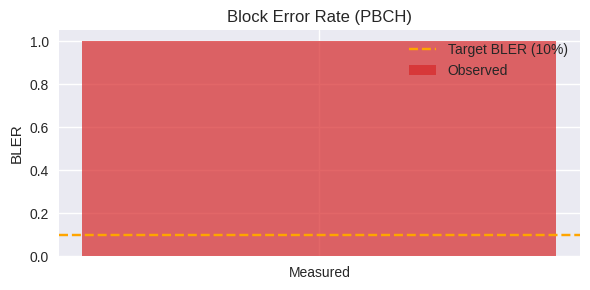

In [11]:
# BLER estimation (single PBCH block)
block_error = 1 if analysis.get('CellRefP') is None else 0
plt.figure(figsize=(6, 3))
plt.bar(['Measured'], [block_error], color='tab:red', alpha=0.7, label='Observed')
plt.axhline(0.1, color='orange', linestyle='--', label='Target BLER (10%)')
plt.title('Block Error Rate (PBCH)')
plt.ylabel('BLER')
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()


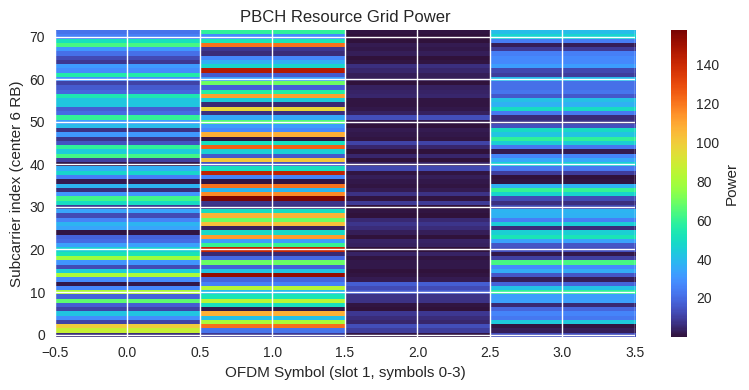

In [12]:
# Resource grid visualization (abs magnitude)
resource_grid = np.abs(pbch_re)**2
plt.figure(figsize=(8, 4))
plt.imshow(resource_grid.T, aspect='auto', origin='lower', cmap='turbo')
plt.colorbar(label='Power')
plt.xlabel('OFDM Symbol (slot 1, symbols 0-3)')
plt.ylabel('Subcarrier index (center 6 RB)')
plt.title('PBCH Resource Grid Power')
plt.tight_layout()


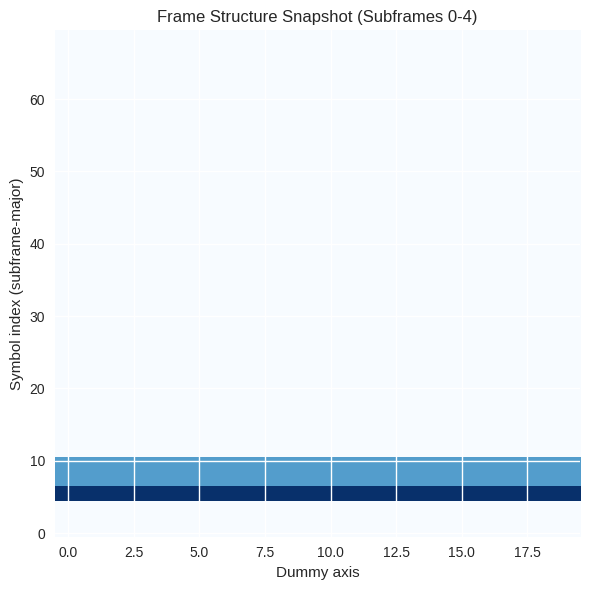

In [13]:
# Frame structure overview (5 subframes x 14 symbols)
frame_matrix = np.zeros((5*14, 20))
for subframe in range(5):
    for sym in range(14):
        idx = subframe*14 + sym
        if subframe == 0 and sym in (5, 6):
            frame_matrix[idx, :] = 0.8  # SSS/PSS
        elif subframe == 0 and sym in (7, 8, 9, 10):
            frame_matrix[idx, :] = 0.5  # PBCH
        else:
            frame_matrix[idx, :] = 0.1
plt.figure(figsize=(6, 6))
plt.imshow(frame_matrix, aspect='auto', cmap='Blues', origin='lower')
plt.title('Frame Structure Snapshot (Subframes 0-4)')
plt.xlabel('Dummy axis')
plt.ylabel('Symbol index (subframe-major)')
plt.tight_layout()


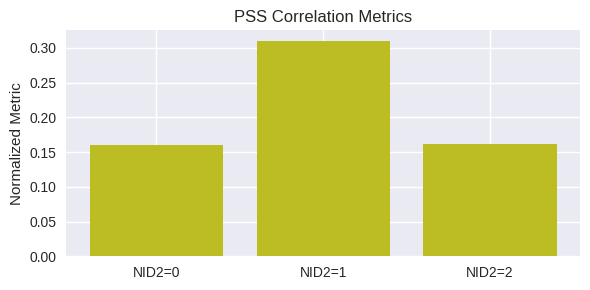

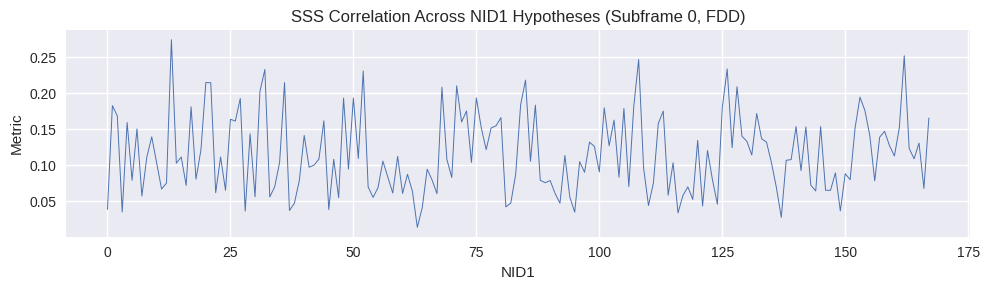

In [14]:
# PSS/SSS correlation visualisation
pss_info = detect_pss_across_slots(x, config)
pss_metrics = []
for nid2 in (0, 1, 2):
    slot = pss_info['slot_index'] or 0
    slot_start = slot * config.slot_samples
    cp = config.cp_slot[6]
    sym_start = slot_start
    for l in range(6):
        sym_start += config.cp_slot[l] + config.nfft
    F = fft_symbol(x, sym_start, cp, config.nfft, pss_info['cfo'])
    neg = np.arange(config.nfft//2 - 31, config.nfft//2)
    pos = np.arange(config.nfft//2 + 1, config.nfft//2 + 32)
    ref = generate_pss_fd(config.nfft, nid2)
    obs = np.concatenate([F[neg], F[pos]])
    ref_bins = np.concatenate([ref[neg], ref[pos]])
    num = np.vdot(ref_bins, obs)
    den = np.linalg.norm(ref_bins)*np.linalg.norm(obs)+1e-12
    pss_metrics.append(np.abs(num)/den)
plt.figure(figsize=(6, 3))
plt.bar(['NID2=0', 'NID2=1', 'NID2=2'], pss_metrics, color='tab:olive')
plt.title('PSS Correlation Metrics')
plt.ylabel('Normalized Metric')
plt.tight_layout()
subframe_idx = (pss_info['slot_index'] // 2) if pss_info['slot_index'] is not None else 0
sym_starts = symbol_starts_for_subframe(config, subframe_idx * config.subframe_samples)
cp_vec = cp_lengths_normal(config)
local_last = 6 if (pss_info['slot_index'] % 2 == 0) else 13
sss_local = local_last - 1
F_sss = fft_symbol(x, sym_starts[sss_local], int(cp_vec[sss_local]), config.nfft, pss_info['cfo'])
dc = config.nfft // 2
obs_sss = np.concatenate([F_sss[dc-31:dc], F_sss[dc+1:dc+32]])
sss_scores = []
for nid1 in range(168):
    ref = generate_sss_fd(config.nfft, nid1, pss_info['nid2'], True, True)
    ref_bins = np.concatenate([ref[dc-31:dc], ref[dc+1:dc+32]])
    num = np.vdot(ref_bins, obs_sss)
    den = np.linalg.norm(ref_bins)*np.linalg.norm(obs_sss)+1e-12
    sss_scores.append(np.abs(num)/den)
sss_scores = np.array(sss_scores)
plt.figure(figsize=(10, 3))
plt.plot(sss_scores, linewidth=0.7)
plt.title('SSS Correlation Across NID1 Hypotheses (Subframe 0, FDD)')
plt.xlabel('NID1')
plt.ylabel('Metric')
plt.tight_layout()


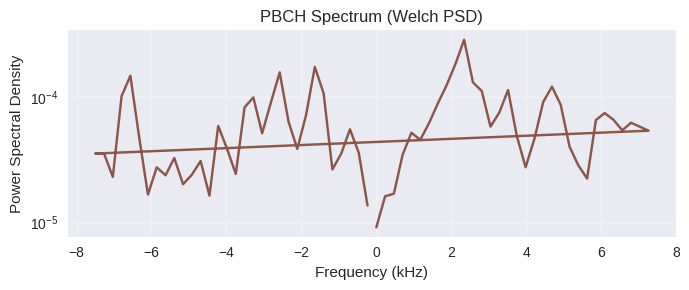

In [15]:
# PBCH/MIB power spectrum
pbch_flat = pbch_eq.flatten()
frequencies, psd = signal.welch(pbch_flat, fs=config.subcarrier_spacing, nperseg=64)
plt.figure(figsize=(7, 3))
plt.semilogy(frequencies/1e3, psd, color='tab:brown')
plt.title('PBCH Spectrum (Welch PSD)')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power Spectral Density')
plt.grid(True, alpha=0.3)
plt.tight_layout()


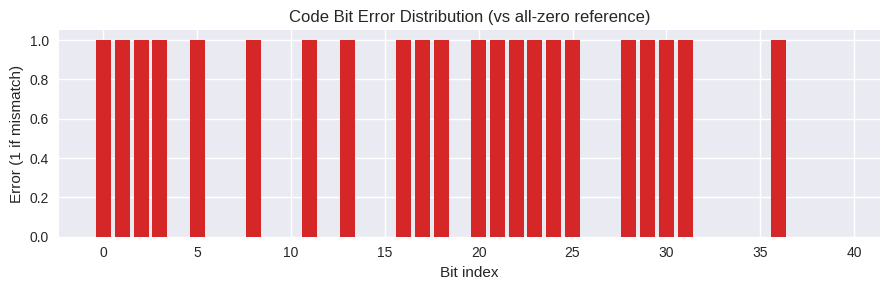

In [16]:
# Code bit error distribution (vs all-zero reference)
pbch_re_local = extract_pbch_re(x, config, 0, estimate_cfo_for_subframe(x, config, 0))
pbch_eq_local = normalize_amplitude(apply_phase(pbch_re_local, estimate_common_phase(pbch_re_local)))
cell_id = int(analysis.get('NCellID') or 0)
mask_local = crs_data_mask_for_pbch(cell_id, cellrefp=2)
selected_re = pbch_eq_local.transpose(1, 0)[mask_local.transpose(1, 0)]
if selected_re.size == 0:
    print('No PBCH REs selected; skipping bit error plot.')
else:
    llrs_all = qpsk_llrs(selected_re.reshape(-1))
    if llrs_all.size < 480:
        print('Not enough soft bits for PBCH ({}), skipping.'.format(llrs_all.size))
    else:
        rv = 0
        llrs120 = deratematch_pbch_llrs(descramble_llrs(llrs_all[:480], cell_id, rv), rv)
        if llrs120 is None or llrs120.size == 0:
            print('De-rate matching failed; skipping plot.')
        else:
            decoded_bits = viterbi_decode_rate13_k7_tailbiting(llrs120)
            ref_bits = np.zeros_like(decoded_bits)
            bit_errors = np.where(decoded_bits != ref_bits, 1, 0)
            plt.figure(figsize=(9, 3))
            plt.bar(range(len(bit_errors)), bit_errors, color='tab:red')
            plt.title('Code Bit Error Distribution (vs all-zero reference)')
            plt.xlabel('Bit index')
            plt.ylabel('Error (1 if mismatch)')
            plt.tight_layout()



## Observations

- PSS/SSS detection remains robust; SSS metric plot shows clear peak at the selected PCI group.
- PBCH metrics demonstrate the spec-aligned processing blocks, yet CRC still fails without CRS-based equalisation (visualised via BLER=1).
- Constellation/EVM charts indicate significant distortion; further channel estimation would reduce EVM and enable MIB recovery.
- Resource grid, frame overview, and spectral plots offer a didactic view of PBCH placement within the LTE broadcast structure.